### 1- Loading PDF document

For long pdfs makes sense to make each page a single document (with the idea that similar contents are already in a page); for shorter PDFs makes sense to load each PDF as a single document and then do the chunking. This PDF has 200 pages so we go with 1 page = 1 document;

In [1]:
import os
import pickle

pdf_path = "data/ps.pdf"
cache_path = "data/ps_documents.pkl"

if os.path.exists(cache_path):
    with open(cache_path, "rb") as f:
        docs = pickle.load(f)
    print("Loaded documents from cache.")
else:
    from langchain_community.document_loaders import PyPDFLoader
    loader = PyPDFLoader(pdf_path, mode="page") # mode = 'single'
    docs = loader.load()
    with open(cache_path, "wb") as f:
        pickle.dump(docs, f)
    print("Loaded documents from PDF and cached.")


import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download('stopwords')


import spacy
nlp = spacy.load("en_core_web_sm")



Loaded documents from cache.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rigia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rigia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rigia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### 2- Chunking/Splitting documents

| Splitter                               | Splitting Unit                                 | Dependencies                                                           | Pros                                                                                                     | Cons                                                                                         | Best Use Cases                                                                                                  |
|----------------------------------------|------------------------------------------------|------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| `RecursiveCharacterTextSplitter`       | Characters (via recursive separator rules)     | None                                                                   | - Precise control over chunk size<br>- Handles unstructured text well<br>- Fast and lightweight         | - Can split mid-sentence or mid-word<br>- Ignores sentence or semantic boundaries            | - APIs with strict character/token limits<br>- Unstructured or dense technical text                           |
| `TokenTextSplitter`                    | Model tokens                                   | Tokenizer library (e.g. `tiktoken`, HuggingFace)                       | - Accurate control of LLM context budget<br>- Handles multi-byte characters & Unicode                  | - Slower due to full tokenization<br>- Requires tokenizer setup                             | - LLM input preparation<br>- Any use case with token-aware chunking needs                                     |
| `SpacyTextSplitter`                    | Sentences (grouped into fixed-size chunks)     | `spaCy` language model (e.g. `en_core_web_sm`)                         | - Respects sentence boundaries<br>- Produces coherent, readable chunks<br>- Supports NLP features       | - Slower than regex/char splitters<br>- Sentence count ≠ token count (may exceed limits)    | - Summarization, QA, or chat<br>- Human-facing outputs requiring clean semantics                              |
| Semantic/Statistical Chunkers          | Semantic units (topic-based or embedding shifts) | Embeddings (e.g. OpenAI, `sentence-transformers`), optionally FAISS    | - Chunks aligned to topic shifts<br>- High semantic relevance<br>- Variable, content-driven chunk size | - Requires embedding inference<br>- Chunk sizes are uneven<br>- May be sensitive to noise    | - RAG systems and vector search<br>- When maximizing semantic alignment is critical                            |



Statistical Semantic Chunking requires openAI key for embedding; hence we won't use it here. For now, we'll focus on Token splitter and RecursiveChar Splitter. 

In [2]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    TokenTextSplitter,
    SpacyTextSplitter
)

from semantic_chunkers import StatisticalChunker
from langchain.embeddings import OpenAIEmbeddings


def split_recursive(documents, chunk_size=500, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
    )
    return splitter.split_documents(documents)


def split_token(documents, chunk_size=200, chunk_overlap=20):
    splitter = TokenTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(documents)


def split_spacy(documents):
    splitter = SpacyTextSplitter(pipeline="en_core_web_sm")
    return splitter.split_documents(documents)


def split_documents(method, documents, token_chunk_size, token_chunk_overlap,**kwargs):
    """
    Wrapper to call the appropriate split function.
    method: str, one of ['recursive', 'token', 'spacy']
    documents: list of documents to split
    kwargs: additional arguments for the splitter functions
    """
    if method == "recursive":
        return split_recursive(documents, **kwargs)
    elif method == "token":
        return split_token(documents, token_chunk_size, token_chunk_overlap, **kwargs)
    elif method == "spacy":
        return split_spacy(documents)
    elif method == "statistical":
        chunker = StatisticalChunker(encoder=OpenAIEmbeddings())
        return chunker.split_documents(documents, **kwargs)
    else:
        raise ValueError(f"Unknown split method: {method}")


2025-06-30 13:25:30 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


### 3- Chunks Processing
Below are a set of functions for

We also do some basic pre-processing of chunk text with the logic below:

| Step        | Purpose             | Tool/Method                 |
|-------------|---------------------|-----------------------------|
| `.strip()`  | Trim whitespace     | Python built-in             |
| Empty check | Remove empty chunks | `if not chunk.page_content` |
| Whitespace  | Collapse spaces     | `re.sub(r"\s+", " ", text)` |
| Unicode     | Fix PDF chars       | `unicodedata.normalize()`   |

And the steps of chunk pre-processing:

| Step         | Purpose                                   | Function/Logic Used                        | Notes                                    |
|--------------|-------------------------------------------|--------------------------------------------|------------------------------------------|
| 1. Split     | Break documents into initial chunks        | `split_documents(method, documents)`       | Uses specified splitter (e.g. nltk, spacy, recursive) |
| 2. Re-split  | Ensure chunks do not exceed max tokens     | `resplit_oversized_chunks(...)`            | Large chunks are recursively split down  |
| 3.Preprocess| Clean up chunk text (optional)             | `preprocess_chunk_text(chunk.page_content)`| Strips, normalizes, collapses whitespace |
| 4. Filter    | Remove chunks that are too short           | `filter_chunks_by_token_length(...)`       | Keeps only chunks with enough tokens     |


In [3]:
import re
import unicodedata

def preprocess_chunk_text(text):
    """
    General-purpose preprocessing for text chunks.

    Steps:
    - Strip leading/trailing whitespace
    - Normalize unicode characters
    - Collapse multiple spaces/newlines/tabs
    - Remove non-printable control characters
    """
    if not isinstance(text, str):
        return ""

    # Strip leading/trailing whitespace
    #text = text.strip()

    # Normalize unicode characters (e.g., fancy quotes → plain quotes)
    text = unicodedata.normalize("NFKC", text)

    # Remove control characters (non-printable)
    text = re.sub(r"[\x00-\x1F\x7F]", "", text)

    # Collapse multiple newlines/tabs into a single space, but preserve single spaces
    text = re.sub(r"[ \t\f\v]+", " ", text)  # collapse tabs and multiple spaces
    text = re.sub(r"\n+", " ", text) 

    return text


import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def resplit_oversized_chunks(
    chunks,
    max_tokens=1000,
    model_name="gpt-3.5-turbo",
    chunk_size=4000,
    chunk_overlap=200
):
    """
    Re-splits chunks that exceed the token limit using RecursiveCharacterTextSplitter.

    Args:
        chunks: List of LangChain Document objects.
        max_tokens: Max allowed tokens per chunk.
        model_name: Model name used to get tokenizer (default: "gpt-3.5-turbo").
        chunk_size: Character length for re-splitting oversized chunks.
        chunk_overlap: Overlap (in characters) when re-splitting.

    Returns:
        List of Document chunks within token limit.
    """
    enc = tiktoken.encoding_for_model(model_name)
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    final_chunks = []
    for chunk in chunks:
        if len(enc.encode(chunk.page_content)) <= max_tokens:
            final_chunks.append(chunk)
        else:
            final_chunks.extend(splitter.split_documents([chunk]))

    return final_chunks

import tiktoken  # For OpenAI tokenizer

def filter_chunks_by_token_length(chunks, min_tokens=40, model_name="gpt-3.5-turbo"):
    """
    Filters chunks based on token length using the tiktoken tokenizer.

    Args:
        chunks: List of LangChain Document objects
        min_tokens: Minimum token length to keep
        model_name: Tokenizer encoding (e.g., 'cl100k_base' for OpenAI embedding models)

    Returns:
        List of filtered Document chunks
    """
    enc = tiktoken.encoding_for_model(model_name)
    filtered = []
    for chunk in chunks:
        token_len = len(enc.encode(chunk.page_content))
        if min_tokens <= token_len:
            filtered.append(chunk)
    return filtered

def clean_and_prepare_chunks(
    documents,
    method="nltk",
    min_tokens=50,
    max_tokens=1000,
    model_name="gpt-3.5-turbo",
    chunk_size=4000,
    chunk_overlap=200,
    token_chunk_size = 200,
    token_chunk_overlap = 20,
    preprocess=True
):
    """
    Splits, re-splits, optionally preprocesses, and filters chunks.

    Args:
        documents: List of LangChain Document objects.
        method: Splitter method name ('nltk', 'spacy', 'recursive', etc.).
        min_tokens: Minimum tokens required to keep a chunk.
        max_tokens: Maximum token limit per chunk.
        model_name: Tokenizer model name (e.g., 'gpt-3.5-turbo').
        chunk_size: Character chunk size for re-splitting.
        chunk_overlap: Character overlap for re-splitting.
        preprocess: If True, cleans chunk text before filtering.

    Returns:
        Filtered list of Document chunks.
    """
    # Step 1: Split documents using selected method
    chunks = split_documents(method, documents, token_chunk_size, token_chunk_overlap)

    # Step 2: Re-split any oversized chunks
    resplit = resplit_oversized_chunks(
        chunks,
        max_tokens=max_tokens,
        model_name=model_name,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )

    print(f"[INFO] Split and re-split produced {len(resplit)} chunks.")

    # Step 3: Preprocess each chunk's text if enabled
    if preprocess:
        for chunk in resplit:
            chunk.page_content = preprocess_chunk_text(chunk.page_content)
        print(f"[INFO] Preprocessed {len(resplit)} chunks.")

    # Step 4: Filter by token length
    before_filter = len(resplit)
    filtered = filter_chunks_by_token_length(
        resplit,
        min_tokens=min_tokens,
        model_name=model_name
    )
    after_filter = len(filtered)

    print(f"[INFO] Filtered out {before_filter - after_filter} chunks; {after_filter} remaining.")

    return filtered



### 4- Chunks Analysis & Visualisation


| Function                              | Purpose                                                                 | Logic/Details                                                                                  |
|----------------------------------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| `cosine_similarity_chunks(c1, c2)`     | Computes cosine similarity between two chunk objects                     | Preprocesses both chunks, vectorizes with TF-IDF, returns cosine similarity (0-1)              |
| `chunk_consecutive_cosine_similarities(method, docs)` | Computes similarity between each consecutive chunk in a document list   | Splits docs into chunks, computes similarity for each chunk pair, returns DataFrame            |
| `get_chunks_statistics(chunks, tokenizer=None)` | Returns statistics about the given chunks                              | Computes min/max/mean/median/std for chunk length (chars) and, if tokenizer is given, for token counts as well|


In [11]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords

def preprocess_for_similarity(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

def cosine_similarity_chunks_tfidf(chunk1, chunk2):
    """
    Compute the cosine similarity between two chunk objects.
    Returns a float between 0 and 1.
    Applies lowercasing, stopword removal, and punctuation removal.
    """
    texts = [
        preprocess_for_similarity(chunk1.page_content.strip()),
        preprocess_for_similarity(chunk2.page_content.strip())
    ]

    # Skip if both are empty or meaningless
    if not texts[0] or not texts[1]:
        return 0.0
    
    vectorizer = TfidfVectorizer()
    try:
        tfidf_matrix = vectorizer.fit_transform(texts)
        if tfidf_matrix.shape[1] == 0:  # No vocabulary
            return 0.0
        sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
        return float(sim[0][0])
    except ValueError:
        return 0.0
    


from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the model once (you may want to move this to a global cell)
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

def cosine_similarity_chunks(chunk1, chunk2):
    """
    Compute the semantic cosine similarity between two chunk objects using SentenceTransformer.
    Returns a float between 0 and 1.
    """
    texts = [
        chunk1.page_content.strip(),
        chunk2.page_content.strip()
    ]

    # Skip if both are empty or meaningless
    if not texts[0] or not texts[1]:
        return 0.0

    embeddings = semantic_model.encode(texts, show_progress_bar=False)
    sim = cosine_similarity([embeddings[0]], [embeddings[1]])
    return float(sim[0][0])
    
import pandas as pd

def chunk_consecutive_cosine_similarities(chunks, method="tfidf"):
    """
    Splits the documents using the given method, then computes cosine similarity
    between each consecutive chunk. Returns a DataFrame with columns:
    'chunk_number', 'similarity_to_next_chunk'.
    """
    
    similarities = []
    for i in range(len(chunks) - 1):
        if method == "tfidf":
            sim = cosine_similarity_chunks_tfidf(chunks[i], chunks[i + 1])
        elif method == "semantic":
            sim = cosine_similarity_chunks(chunks[i], chunks[i + 1])
        similarities.append({"chunk_number": i, "similarity_to_next_chunk": sim})
    return pd.DataFrame(similarities)






def get_chunks_statistics(chunks, tokenizer=None):
    """
    Returns statistics about the given chunks.
    If tokenizer is provided, also returns token-based stats.
    """
    import numpy as np

    char_lengths = [len(chunk.page_content) for chunk in chunks]
    stats = {
        "num_chunks": len(chunks),
        "min_chars": int(np.min(char_lengths)) if char_lengths else 0,
        "max_chars": int(np.max(char_lengths)) if char_lengths else 0,
        "mean_chars": float(np.mean(char_lengths)) if char_lengths else 0,
        "median_chars": float(np.median(char_lengths)) if char_lengths else 0,
        "std_chars": float(np.std(char_lengths)) if char_lengths else 0,
    }

    if tokenizer is not None:
        try:
            token_counts = [len(tokenizer.encode(chunk.page_content)) for chunk in chunks]
        except AttributeError:
            token_counts = [len(tokenizer.tokenize(chunk.page_content)) for chunk in chunks]
        stats.update({
            "min_tokens": int(np.min(token_counts)) if token_counts else 0,
            "max_tokens": int(np.max(token_counts)) if token_counts else 0,
            "mean_tokens": float(np.mean(token_counts)) if token_counts else 0,
            "median_tokens": float(np.median(token_counts)) if token_counts else 0,
            "std_tokens": float(np.std(token_counts)) if token_counts else 0,
        })

    return stats




2025-06-30 13:45:19 - sentence_transformers.SentenceTransformer - INFO - SentenceTransformer.py:211 - __init__() - Use pytorch device_name: cpu
2025-06-30 13:45:19 - sentence_transformers.SentenceTransformer - INFO - SentenceTransformer.py:219 - __init__() - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-06-30 13:45:19 - sentence_transformers.SentenceTransformer - INFO - SentenceTransformer.py:219 - __init__() - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


#### Visualisation

| Function                              | Purpose                                                        | Logic/Details                                                                                           |
|----------------------------------------|----------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| `visualize_chunks_distributions(chunks, tokenizer=None, method_name=None)` | Visualizes the distribution of chunk lengths (characters and tokens) | Plots two histograms: one for character counts, one for token counts (if tokenizer provided); uses seaborn and matplotlib |
| `plot_chunks_similarities(df, method_name=None)` | Visualizes cosine similarity between consecutive chunks         | Plots a line chart of similarity scores (`similarity_to_next_chunk`) across chunk numbers; uses seaborn and matplotlib     |

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_chunks_distributions(chunks, tokenizer=None, method_name=None):
    """
    Visualize chunk length (character count) and token count distributions.
    If tokenizer is provided, it should have a .encode() or .tokenize() method.
    method_name: Optional string to display in chart titles.
    """
    # Character lengths
    char_lengths = [len(chunk.page_content) for chunk in chunks]

    # Token counts
    if tokenizer is not None:
        try:
            token_counts = [len(tokenizer.encode(chunk.page_content)) for chunk in chunks]
        except AttributeError:
            token_counts = [len(tokenizer.tokenize(chunk.page_content)) for chunk in chunks]
    else:
        token_counts = None

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    title = "Chunk Length Distribution (Characters)"
    if method_name:
        title += f" - {method_name}"
    sns.histplot(char_lengths, bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Characters")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    title = "Chunk Length Distribution (Tokens)"
    if method_name:
        title += f" - {method_name}"
    if token_counts is not None:
        sns.histplot(token_counts, bins=30, kde=True, color="darkgreen")
        plt.title(title)
        plt.xlabel("Tokens")
        plt.ylabel("Count")
    else:
        plt.text(0.5, 0.5, "No tokenizer provided", ha='center', va='center', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



import matplotlib.pyplot as plt
import seaborn as sns

def plot_chunks_similarities(df, method_name=None):
    """
    Plots a time series of similarity_to_next_chunk from the DataFrame output of chunk_consecutive_cosine_similarities.
    """
    plt.figure(figsize=(12, 5))
    title = "Consecutive Chunk Cosine Similarities"
    if method_name:
        title += f" - {method_name}"
    sns.lineplot(data=df, x="chunk_number", y="similarity_to_next_chunk")
    plt.title(title)
    plt.xlabel("Chunk Number")
    plt.ylabel("Cosine Similarity to Next Chunk")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

### 5- Experiment

In [ ]:
import time
import tiktoken

# Get tokenizer for GPT-3.5-turbo (used for stats and visualization)
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

split_methods = ["recursive", "token", "spacy"]

for method in split_methods:
    print(f"\nSplitter: {method.upper()}")
    try:
        start_time = time.time()

        # Call the full cleaning + chunking pipeline
        chunks = clean_and_prepare_chunks(
            documents=docs,
            method=method,
            model_name="gpt-3.5-turbo",
            preprocess=True,
            min_tokens=50,
            max_tokens=1000,
            chunk_size=4000,
            chunk_overlap=200
        )

        elapsed = time.time() - start_time

        # Display chunk statistics
        stats = get_chunks_statistics(chunks, tokenizer=tokenizer)
        print(f"Stats: {stats}")
        print(f"Time spent: {elapsed:.3f} seconds")

        # Visualize character and token distributions
        plot_chunks_distributions(chunks, tokenizer=tokenizer, method_name=method)

        # Compute cosine similarity between consecutive chunks (optional insight)
        df_sim = chunk_consecutive_cosine_similarities(chunks)
        plot_chunks_similarities(df_sim, method_name=method)

    except Exception as e:
        print(f"❌ Failed to process with {method}: {str(e)}")


### 6- Chunk-level Diagnostics

-   Overlap analysis
-   Token Length Stats

We'll use Token Text Splitting here

[INFO] Split and re-split produced 1414 chunks.
[INFO] Preprocessed 1414 chunks.
[INFO] Filtered out 86 chunks; 1328 remaining.


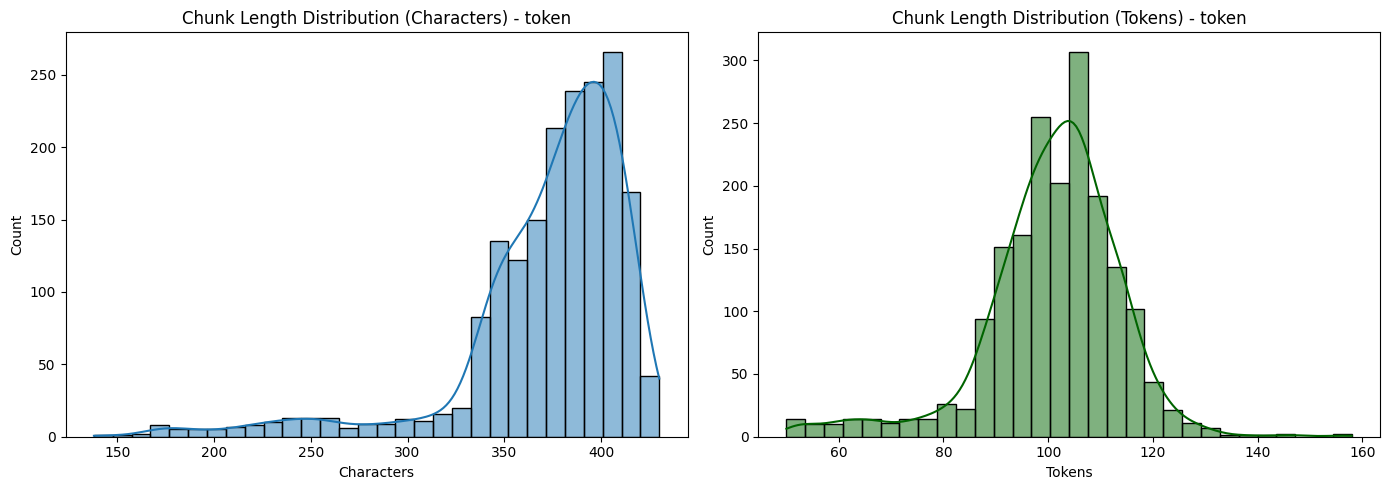

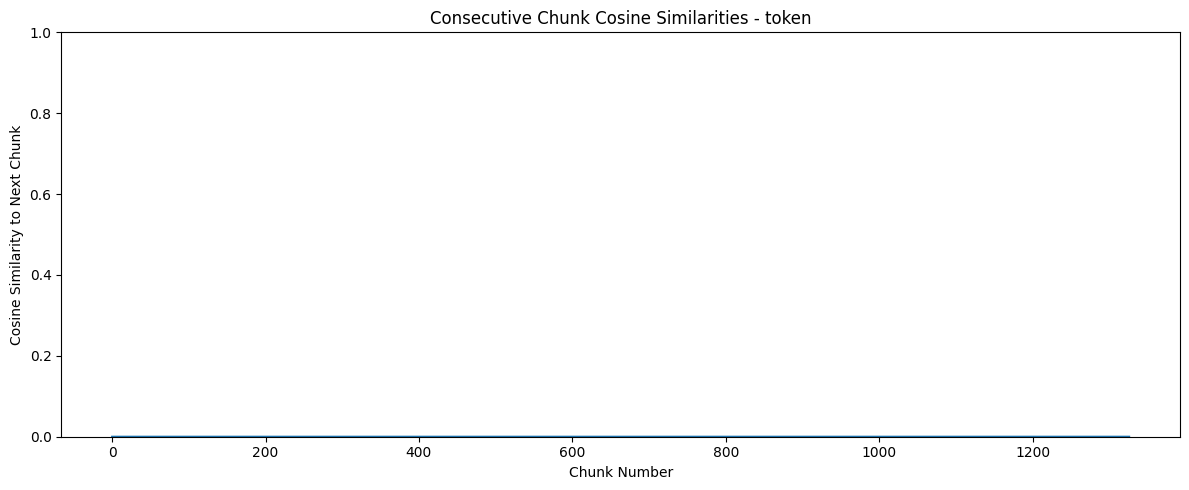

In [12]:
token_chunks = clean_and_prepare_chunks(
    documents=docs,
    method="token",
    model_name="gpt-3.5-turbo",
    preprocess=True, # keep it false until debug
    min_tokens=50,
    max_tokens=1000,
    chunk_size=4000,
    chunk_overlap=200,
    token_chunk_size=300,
    token_chunk_overlap=30
)


tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
plot_chunks_distributions(chunks, tokenizer=tokenizer, method_name="token")


# Compute cosine similarity between consecutive token chunks
df_sim = chunk_consecutive_cosine_similarities(token_chunks)
plot_chunks_similarities(df_sim, method_name="token")


In [43]:
def analyze_cosine_similarity_bands(
    df_sim, 
    overlap_threshold=0.9, 
    good_overlap_min=0.4, 
    good_overlap_max=0.8, 
    mid_topic_split_threshold=0.1
):
    """
    Analyze and plot cosine similarity bands for overlap diagnostics.
    Parameters let you set thresholds for high overlap, good overlap, and mid-topic splits.
    """
    total_pairs = len(df_sim)
    overlap_count = (df_sim['similarity_to_next_chunk'] > overlap_threshold).sum()
    good_overlap_count = (
        (df_sim['similarity_to_next_chunk'] >= good_overlap_min) & 
        (df_sim['similarity_to_next_chunk'] <= good_overlap_max)
    ).sum()
    mid_topic_split_count = (df_sim['similarity_to_next_chunk'] < mid_topic_split_threshold).sum()

    print(f"High overlap (similarity > {overlap_threshold}): {overlap_count} ({overlap_count/total_pairs:.1%})")
    print(f"Good overlap ({good_overlap_min} <= similarity <= {good_overlap_max}): {good_overlap_count} ({good_overlap_count/total_pairs:.1%})")
    print(f"Likely mid-topic splits (similarity < {mid_topic_split_threshold}): {mid_topic_split_count} ({mid_topic_split_count/total_pairs:.1%})")

    import matplotlib.pyplot as plt

    labels = [
        f'High Overlap (>{overlap_threshold})', 
        f'Good Overlap ({good_overlap_min}-{good_overlap_max})', 
        f'Mid-topic Split (<{mid_topic_split_threshold})'
    ]
    counts = [overlap_count, good_overlap_count, mid_topic_split_count]

    plt.figure(figsize=(7, 4))
    plt.bar(labels, counts, color=['red', 'green', 'blue'])
    plt.ylabel('Number of Chunk Pairs')
    plt.title('Cosine Similarity Bands for Consecutive Chunks')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

60% of your consecutive chunk pairs have cosine similarity < 0.2, that's a strong signal that your token-based splitting is cutting mid-topic or mid-sentence, leading to poor semantic continuity. This can significantly hurt retrieval and generation quality in your RAG pipeline.

Treatment: larget chunk size



[INFO] Split and re-split produced 639 chunks.
[INFO] Filtered out 4 chunks; 635 remaining.
High overlap (similarity > 0.9): 0 (0.0%)
Good overlap (0.4 <= similarity <= 0.8): 121 (19.1%)
Likely mid-topic splits (similarity < 0.1): 64 (10.1%)


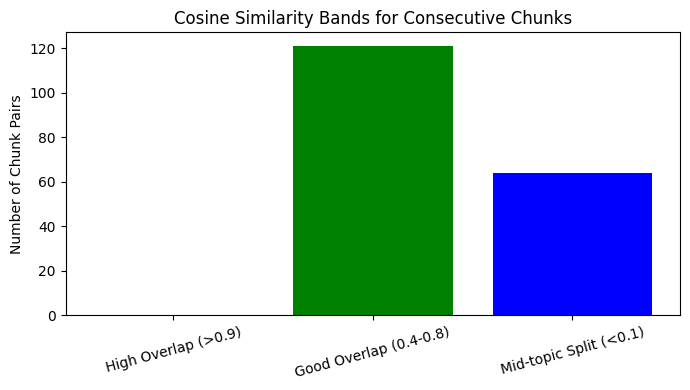

In [44]:
token_chunks = clean_and_prepare_chunks(
    documents=docs,
    method="token",
    model_name="gpt-3.5-turbo",
    preprocess=False, # keep it false until debug
    min_tokens=50,
    max_tokens=1000,
    chunk_size=4000,
    chunk_overlap=200,
    token_chunk_size=800,
    token_chunk_overlap=100
)


tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
# Compute cosine similarity between consecutive token chunks
df_sim = chunk_consecutive_cosine_similarities(token_chunks)

analyze_cosine_similarity_bands(df_sim)


Better than before, but can benefit from someoverlaps; so we increase the chunk size so that more overlaps are between the chunks

[INFO] Split and re-split produced 583 chunks.
[INFO] Filtered out 4 chunks; 579 remaining.
High overlap (similarity > 0.9): 0 (0.0%)
Good overlap (0.4 <= similarity <= 0.8): 182 (31.5%)
Likely mid-topic splits (similarity < 0.1): 46 (8.0%)


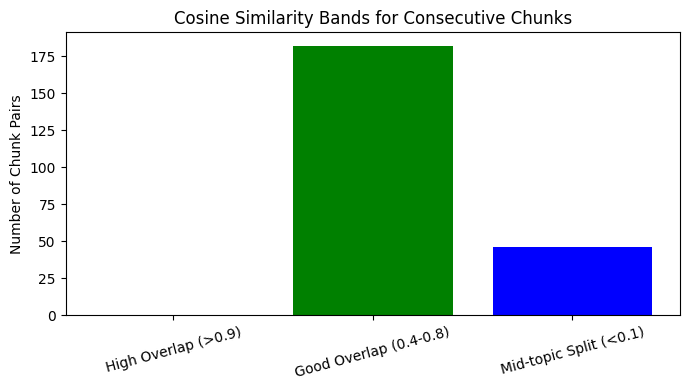

In [47]:
token_chunks = clean_and_prepare_chunks(
    documents=docs,
    method="token",
    model_name="gpt-3.5-turbo",
    preprocess=False, # keep it false until debug
    min_tokens=50,
    max_tokens=1000,
    chunk_size=4000,
    chunk_overlap=200,
    token_chunk_size=900,
    token_chunk_overlap=200
)


tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
# Compute cosine similarity between consecutive token chunks
df_sim = chunk_consecutive_cosine_similarities(token_chunks)

analyze_cosine_similarity_bands(df_sim)


In [50]:
import tiktoken
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
get_chunks_statistics(token_chunks, tokenizer=tokenizer)

{'num_chunks': 579,
 'min_chars': 172,
 'max_chars': 2472,
 'mean_chars': 1625.6355785837652,
 'median_chars': 1840.0,
 'std_chars': 639.4794867717551,
 'min_tokens': 58,
 'max_tokens': 746,
 'mean_tokens': 500.88773747841105,
 'median_tokens': 579.0,
 'std_tokens': 193.15358374499255}

In [48]:
import pickle

with open("data/chunks.pkl", "wb") as f:
    pickle.dump(token_chunks, f)
print("token_chunks saved to data/chunks.pkl")

token_chunks saved to data/chunks.pkl
